In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dtype_dict = {
    'dcn': 'object',
    'seqnum': 'float64',
    'sectitle': 'object',
    'tprice': 'float64',
    'tprice_adj': 'float64',
    'tprice_ar': 'float64',
    'shares': 'float64',
    'shares_adj': 'float64',
    'ticker': 'object', 
    'acqdisp': 'object', 
    'optionsell': 'object',  
    'cleanse': 'object',  
    'trandate_price': 'float64',
    'avg_prccd_3mo': 'float64',
    'cusip': 'object',
    'iid': 'object',
    'tic': 'object',
    'price_diff': 'float64',
    'rolecode3': 'object'
}
date_columns = ['sigdate', 'secdate', 'trandate', 'trandate_ar', 'trandate_datadate', 'fdate', 'cdate', 'maintdate']


# Read the data from CSV and set the dtypes using the dtype_dict
df = pd.read_csv('insider_trading_raw.csv', dtype=dtype_dict, parse_dates=date_columns, low_memory=False)

df['year'] = df['trandate'].dt.year
df['month'] = df['trandate'].dt.month

In [2]:
df['perc_change'] = (df['avg_prccd_3mo'] - df['trandate_price']) / df['trandate_price']
df['va'] = df['perc_change'] * df['trandate_price'] * df['shares_adj']
df.shape

(1001500, 59)

In [3]:
# Step 2: Ensuring each trade is uniquely identified by 'dcn' and 'seqnum'
unique_trades = df.drop_duplicates(subset=['dcn', 'seqnum']).copy()
print(unique_trades.shape)
# Step 3: Extract the calendar month and year
unique_trades['month'] = unique_trades['trandate'].dt.month
unique_trades['year'] = unique_trades['trandate'].dt.year

# Step 4: Calculate the 3-month percent price change
unique_trades['perc_change'] = (unique_trades['avg_prccd_3mo'] - unique_trades['trandate_price']) / unique_trades['trandate_price']

# Define the threshold for considering an insider as a routine trader
threshold_years = 3

# Step 5: Define a function to identify routine traders based on trading in specific months across several years
def identify_routine_traders(past_data, threshold_years):
    # Group by personid, month, and count the number of unique years each person traded in that month
    trades_per_month = past_data.groupby(['personid', 'month'])['year'].nunique().reset_index()
    # Identify routine traders if they have traded in the same month in at least `threshold_years` different years
    routine_traders = trades_per_month[trades_per_month['year'] >= threshold_years]['personid'].unique()
    return routine_traders

# Step 6: Classify insiders at the beginning of each calendar year based on their past trading history
unique_years = sorted(unique_trades['year'].unique())
classified_data = pd.DataFrame()

for year in unique_years:
    # Get past data up to the previous year
    past_data = unique_trades[unique_trades['year'] < year]
    
    # Identify routine traders
    routine_traders = identify_routine_traders(past_data, threshold_years)
    
    # Classify current year's data
    current_year_data = unique_trades[unique_trades['year'] == year].copy()
    current_year_data['trader_type'] = current_year_data['personid'].apply(lambda x: 'Routine' if x in routine_traders else 'Opportunistic')
    
    # Append the classified data to the overall DataFrame
    classified_data = pd.concat([classified_data, current_year_data])

# Reset the index of the final DataFrame
classified_data.reset_index(drop=True, inplace=True)

# Step 7: Group by year and trader_type and calculate the average 3-month percent price change
avg_perc_change_by_year = classified_data.groupby(['year', 'trader_type', 'acqdisp'])['perc_change'].mean().unstack(level=['trader_type', 'acqdisp'])

# Display the average 3-month percent price change by year and trader type
avg_perc_change_by_year

(999298, 59)


trader_type Opportunistic             Routine          
acqdisp                 A         D         A         D
year                                                   
1986             0.090947  0.142988       NaN       NaN
1987             0.014210       NaN       NaN       NaN
1988             0.029176  0.044552       NaN       NaN
1989             0.041313  0.037313       NaN       NaN
1990             0.059648  0.101645 -0.057107       NaN
1991             0.203156  0.010417  0.010351  0.028037
1992             1.825321  2.207396  9.763967       NaN
1993             0.139477  0.145577  0.013490 -0.163355
1994            -0.001273 -0.023008 -0.086132 -0.003007
1995             0.088301  0.076640 -0.031923 -0.003241
1996             0.037774  0.015952  0.024907 -0.008019
1997             0.049425  0.035774  0.019467  0.013475
1998            -0.013138 -0.013992 -0.003479  0.007495
1999             0.072955  0.075766  0.081085  0.161557
2000             0.000014 -0.100841  0.009188  0.015854
2001             0.125814 -0.011364  0.003661 -0.014622
2002             0.068051 -0.003426  0.150409 -0.035280
2003             0.137328  0.117095  0.092318  0.077638
2004             0.038117  0.010375  0.041862  0.036718
2005             0.137010  0.016867  0.018674  0.025230
2006             0.021555  0.018574  0.012490  0.001233
2007             2.369362 -0.014383  0.008005 -0.026698
2008             0.042518 -0.073210 -0.068539 -0.086246
2009             1.269100  0.103809  0.561564  0.170840
2010             1.954219  0.015431  0.067507  0.028592
2011             0.461688 -0.020555  0.140885 -0.000761
2012             0.644308  0.067554  0.061349  0.050433
2013             1.801582  1.147009  1.302728  0.054975
2014             0.089540  0.066002  0.051596  0.021860
2015             0.820099 -0.025277  0.747097  0.024979
2016             0.133880  0.101309  0.115992  0.082941
2017             0.721165  0.023565  0.615227  0.021264
2018             2.794624  0.236490  0.166293  0.051194
2019             0.393636 -0.006701  2.948690  0.002005
2020             0.210346  0.165596  0.128590  0.231971
2021             0.100709 -0.027453  0.531476  0.027182
2022             0.089040 -0.052342  0.087120 -0.128798
2023             0.986323  0.115284  0.841363 -0.021951
2024             0.157983  0.026234  1.372404  0.047244

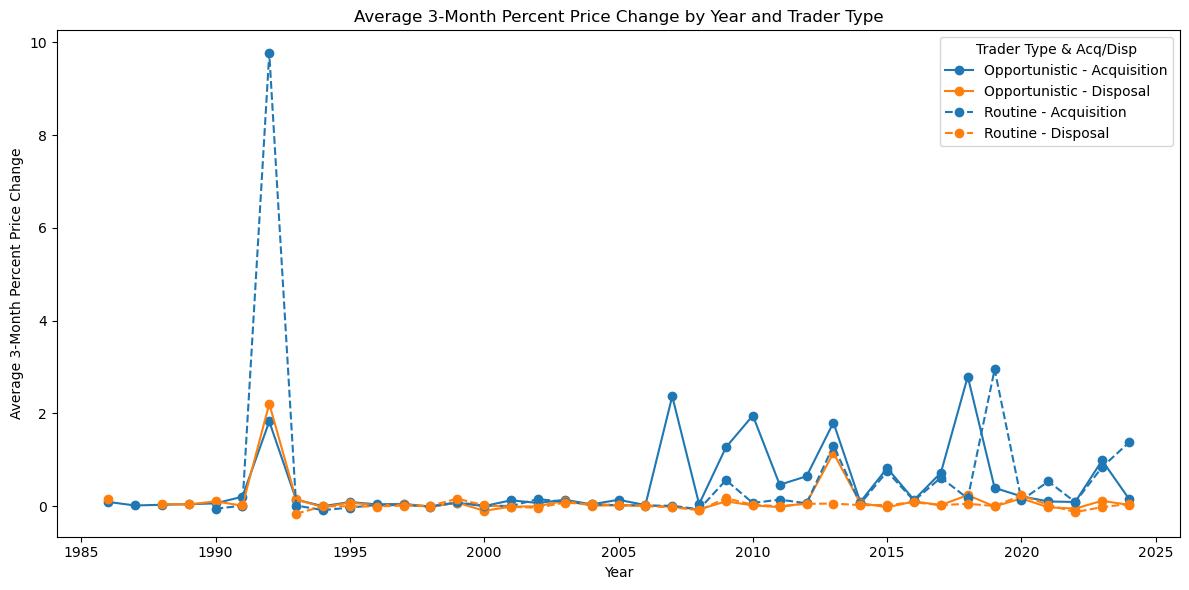

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

# Customizing line style for trader_type and color for acqdisp
line_styles = {
    'Opportunistic': 'solid',
    'Routine': 'dashed'
}

colors = {
    'A': 'tab:blue',
    'D': 'tab:orange'
}

# Plot each series explicitly with custom styles
for trader_type in line_styles:
    for acqdisp_type in colors:
        if (trader_type, acqdisp_type) in avg_perc_change_by_year.columns:
            ax.plot(avg_perc_change_by_year.index, avg_perc_change_by_year[(trader_type, acqdisp_type)],
                    linestyle=line_styles[trader_type], color=colors[acqdisp_type],
                    marker='o', label=f'{trader_type} - {"Acquisition" if acqdisp_type == "A" else "Disposal"}')

# Customize plot 
ax.set_title('Average 3-Month Percent Price Change by Year and Trader Type')
ax.set_xlabel('Year')
ax.set_ylabel('Average 3-Month Percent Price Change')
ax.legend(title='Trader Type & Acq/Disp')
ax.grid(False)

# Save the figure
plt.tight_layout()
plt.savefig('avg_3month_percent_change_by_year_and_trader_type.png')

# Display the plot
plt.show()